# 1. The question:

How to build HOI4 factories in order to maximize military factories output prior to input year?

Well it is possible to start with building only the military factories and seems like it will be optimal for 3-12 months. But what if we want to ensure that our build order will be optimal to produce maximum amount of military equipment on year 1940 for example?

## 1.1 Q-learning

Q-learning - renforecemnt learning algorithm that seeks to find the best action to take given the current state.  
Off-policy bcs the q-learning function learns from actions that are outside the current policy, like taking random actions -> policy isn't needed.  
Q-learning seeks to learn a policy that maximizes the total reward.

## 1.2 What is Q?
Q stands for quality, seems like its all. Quite abstract number.

## 1.3 Q-table
When q-learning is performed q-table is created. Q-table is a matrix with shape of [state, action] and we initialize our values to zero. Then we update and store our q-values after an episode. This q-table becomes a reference table for our agent to select the best action based on the q-value.

## 1.4 Q-learning and making updates
The next step is to interact with the environment and make updates to the state action pairs in our q-table.

### Taking action: explore or exploit

An agent interacts with the enviroment in 1 of 2 ways. 
1. The first is to use the q-table as reference and view all possible actions for a given state. The agent then selects the action based on the max value of those actions. This is known as exploiting since we use the information we have available to us to make a decision.
2. The second way is to take act randomly. This is called exploring. Instead of selecting actions based on the max reward we select an action at random. Acting randomly is important because it allows the agent to explore and discover new states that otherwise may not be selected during the exploration process.

It is possible to balance exploration/exploitation using $\varepsilon$. Percent that would be used for exploration can be set in following way:
```
import random
epsilon = 0.2
if random.uniform(0, 1) < epsilon:
    #Explore: select a random action
else:
    #Exploit: select the action with max value (future reward)
```
### Updating the q-table

The updates occur after each step or action and ends when an episode is done. Done in this case means reaching some terminal point by the agent. A terminal state for example can be anything like landing on a checkout page, reaching the end of some game, completing desired objective, etc. The agent will not learn much after a single episode but eventually with enough exploring it will converge and learn the optimal q-valuer or q-star (Q*)

Here are the 3 basic steps:
1. Agent starts in a state (s1) takes an action (a1) and receives a reward (r1)
2. Agent selects action by referencing Q-table with highest value (max) OR by random (epsilon, ε)
3. Update q-values

```
Q[state, action] = Q[state, action] + lr * (reward + gamma * np.max(Q[new_state, :]) — Q[state, action])
```
`Learning Rate`: lr or learning rate, often referred to as alpha or α, can simply be defined as how much you accept the new value vs the old value. Above we are taking the difference between new and old and then multiplying that value by the learning rate. This value then gets added to our previous q-value which essentially moves it in the direction of our latest update.

`Gamma`: gamma or γ is a discount factor. It’s used to balance immediate and future reward. From our update rule above you can see that we apply the discount to the future reward. Typically this value can range anywhere from 0.8 to 0.99.

`Reward`: reward is the value received after completing a certain action at a given state. A reward can happen at any given time step or only at the terminal time step.

`Max`: np.max() uses the numpy library and is taking the maximum of the future reward and applying it to the reward for the current state. What this does is impact the current action by the possible future reward. This is the beauty of q-learning. We’re allocating future reward to current actions to help the agent select the highest return action at any given state.

`Discount` is a measure of how much we want to care about FUTURE reward rather than immediate reward. Typically, this value will be fairly high, and is between 0 and 1. We want it high because the purpose of Q Learning is indeed to learn a chain of events that ends with a positive outcome, so it's only natural that we put greater importance on long terms gains rather than short term ones.

# 2. Initial Data

In [1]:
import pandas as pd
import datetime
#import random
import numpy as np

In [2]:
start_date = datetime.date(1936, 1, 1)
end_date = datetime.date(1939, 1, 1)
df_ini_germany_manufacture_stats = pd.read_excel('Germany.xlsx').fillna(0).set_index('Region')
df_germany_manufacture_stats = df_ini_germany_manufacture_stats.copy()

## 2.1 CountryStats class

used to store & update economics of the country:
- start_date (game start date)
- curr_date (current ingame date)
- curr_mil_production (current ingame military factories production in 🔨)
- curr_civ_production (current ingame civilian factories production in 🔨)
- cumulative_mil_production (total military 🔨 produced on current moment of time)
- cumulative_civ_production (total civilian 🔨 produced on current moment of time)

todo:
- dockyards are not taken into account (yet)
- factory conversion is not taken into account (yet)



In [3]:
class CountryStats:
    '''
    Needed to input initial parameters of the country economy (amount of factories & infrastracture)
    '''
    def __init__(self, country_name, df_manufacture_stats):
        self.country_name = country_name
        self.manufacture_stats = df_manufacture_stats.copy()
        self.start_date = datetime.date(1936, 1, 1)
        self.curr_date = self.start_date
        self._update_curr_production()
        self.cum_mil_production = 0
        self.cum_civ_production = 0

    def _update_curr_production(self):
        self.curr_mil_production = self.manufacture_stats['Military factories'].sum()*5
        self.curr_civ_production = self.manufacture_stats['Civilian factories'].sum()*5
        
    def daily_update(self):
        self.cum_civ_production += self.curr_civ_production
        self.cum_mil_production += self.curr_mil_production
        self.curr_date += datetime.timedelta(days = 1)
        
    def get_manufacture_stats(self):
        return self.manufacture_stats
    
    def reset(self, df_manufacture_stats):
        self.curr_date = self.start_date
        self.manufacture_stats = df_manufacture_stats.copy()
        self.cum_mil_production = 0
        self.cum_civ_production = 0

## 2.2 Builder Class

todo:
- building query
- pick construction region
- add residual to the 0 "self.curr_building_progress = 0"
- restrict max infrastructure to 1.0

In [4]:
class Builder:
    def __init__(self, country_name, CountryStats_obj):
        self.country_name = country_name
        self.mil_factory_cost = 7200
        self.civ_factory_cost = 10800
        self.infrastracture_cost = 3000    
        self.curr_building_progress = 0
        
    def start_building(self, CountryStats_obj, to_build):
        build_df = CountryStats_obj.manufacture_stats
        build_df = build_df[build_df['Available building slots'] > 0]
        randomizing_building_region_number = np.random.randint(0, len(build_df))
        region_name = build_df.iloc[randomizing_building_region_number].name
        if to_build == 0:
            self.building_object = ['mil_factory', self.mil_factory_cost, region_name, 'Military factories']
        if to_build == 1:
            self.building_object = ['civ_factory', self.civ_factory_cost, region_name, 'Civilian factories']
        elif to_build == 2:#  and infracstructure < 1
            self.building_object = ['infrastructure', self.infrastracture_cost, region_name, 'Infrastructure']
    
    def building_progress_upd(self, CountryStats_obj):
        self.curr_building_progress += CountryStats_obj.curr_civ_production/self.building_object[1]
        
    def complete_building(self, CountryStats_obj):
        df = CountryStats_obj.get_manufacture_stats()
        df.loc[self.building_object[2],self.building_object[3]] = df.loc[self.building_object[2],self.building_object[3]] + 1
        df['Current factories'] = df['Military factories'] + df['Civilian factories'] + df['Shipyards'] + df['Fuel storage']
        df['Available building slots'] = df['Max available building slots'] - df['Current factories']
        CountryStats_obj.manufacture_stats = df
        CountryStats_obj._update_curr_production()
        
    def control_room(self, CountryStats_obj, Qlearning_obj):

        # new construction started
        curr_date = CountryStats_obj.curr_date
        if self.curr_building_progress == 0:
            decision = Qlearning_obj.decision_qtable_upd(curr_date)
            self.start_building(CountryStats_obj, decision)
        
        # construction completed & new construction started
        elif self.curr_building_progress >= 1:
            self.complete_building(CountryStats_obj)
            self.curr_building_progress = 0
            decision = Qlearning_obj.decision_qtable_upd(curr_date)
            self.start_building(CountryStats_obj, decision)

        CountryStats_obj.daily_update()
        self.building_progress_upd(CountryStats_obj)
    
    def execute_multiple_episodes(self, CountryStats_obj, Qlearning_obj, df_germany_manufacture_stats):
        episodes_reward = []
        production_stats = []
        counter_list = []
        counter = 0
        self.max_cum_mil_production = 0
        for i in range(Qlearning_obj.episodes):
            counter += 1
            CountryStats_obj.reset(df_germany_manufacture_stats)
            CountryStats_obj.get_manufacture_stats()
            while CountryStats_obj.curr_date < (end_date):
                self.control_room(CountryStats_obj, Qlearning_obj)
            
            # in case if the record is beaten
            if CountryStats_obj.cum_mil_production > self.max_cum_mil_production:
                Qlearning_obj.hand_reward_for_the_record()
                self.max_cum_mil_production = CountryStats_obj.cum_mil_production
                total_reward = Qlearning_obj.construction_episode_reward + Qlearning_obj.count_reward_for_the_record() * Qlearning_obj.learning_rate
            else:
                total_reward = Qlearning_obj.construction_episode_reward
                
            production_stats.append(CountryStats_obj.cum_mil_production)
            episodes_reward.append(total_reward)
            counter_list.append(counter)
            Qlearning_obj.reset_episode()    
        return [counter_list, production_stats, episodes_reward]
            
        

## 2.3 CountryModifiers class

- Under construction

In [5]:
start_factories_production_buff = 1
step_factories_production_buff = 0,2
max_factories_production_time = [start_date + datetime.timedelta(days = (126+168*1)),
                                 start_date + datetime.timedelta(days = (126+168*2)),
                                 start_date + datetime.timedelta(days = (126+168*3)),
                                 start_date + datetime.timedelta(days = (126+168*4)),
                                 start_date + datetime.timedelta(days = (126+168*5))]

start_factories_construction_buff = 1
step_factories_production_buff = 0,1

## 2.4 Qlearning class

$Q^{new}(s_t, a_t) \leftarrow (1- \alpha) \times Q(s_t,a_t) + \alpha \times (r_t + \gamma \times maxQ(s_{t+1},a))$

- current_q = $Q(s_t,a_t)$
- max_future_q = $ maxQ(s_{t+1},a)$
- new_q = $Q^{new}(s_t, a_t)$

In [6]:
class Qlearning:
    def __init__(self):
        self.learning_rate = 0.1
        self.episodes = 25000 # iterations
        self.epsilon = 0.05 # 5% for exploration
        self.discount = 0.9
        self.q_table = self._generate_q_table()
        self.reward = 5
        self.bonus_reward = 0 #50
        self.construction_episode_reward = 0
        self.episode_history = {}
        
    def _generate_q_table(self):
        q_table = {}
        for i in pd.date_range(start_date, end_date):
            q_table[i.date()] = [np.random.randint(0, 3) for i in range(3)] # 0 for i in range(3) bcs only 3 buildings possible
        return q_table 
    
    def decision_qtable_upd(self, decision_date):
        if np.random.random() > self.epsilon:
            decision = np.argmax(self.q_table[decision_date]) # q-table decision
        else:
            decision = np.random.randint(0, 3)
        current_q = self.q_table[decision_date][decision]
        self.episode_history[decision_date] = [decision]
        try:
            max_future_q = np.max(self.q_table[decision_date+1])
        except: # out of bonds
            max_future_q = np.max(self.q_table[decision_date]) # to prevent out of bounds
            
        if decision == 0:
            reward = self.reward
        else:
            reward = 0
        
        new_q = (1 - self.learning_rate) * current_q + self.learning_rate * (reward + self.discount * max_future_q)
        self.construction_episode_reward += self.reward
        self.q_table[decision_date][decision] = new_q
        return decision
    
    def reset_episode(self):
        self.construction_episode_reward = 0
        self.episode_history = {}
    
    def count_reward_for_the_record(self):
        l = len([i for i in self.episode_history.keys()])
        res = l * self.bonus_reward
        return res
    
    def hand_reward_for_the_record(self):
        keys = [i for i in self.episode_history.keys()]
        vals = [i for i in self.episode_history.values()]
        for k,v in list(zip(keys,vals)):
            self.q_table[k][v[0]] += self.bonus_reward * self.learning_rate

   

In [7]:
df_germany_manufacture_stats = df_ini_germany_manufacture_stats.copy()

### Creating germany object
germany = CountryStats('Germany', df_germany_manufacture_stats)
print(germany.curr_date)

### Creating germany builder object
germany_builder = Builder('Germany', germany)

### Creating Qlearning object
q_learning = Qlearning()

1936-01-01


In [8]:
result = germany_builder.execute_multiple_episodes(germany, q_learning, df_germany_manufacture_stats)

[Text(0,0.5,'reward'), Text(0.5,0,'episode')]

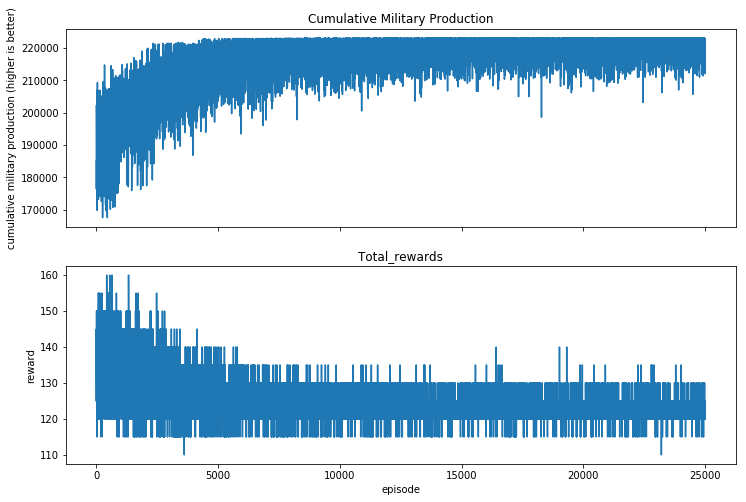

In [20]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12, 8))
ax1.set_title('Cumulative Military Production')
ax2.set_title('Total_rewards')
x1, y1 = result[0], result[1]
x2, y2 = result[0], result[2]
ax1.plot(x1,y1)
ax2.plot(x2,y2)
ax1.set(ylabel='cumulative military production (higher is better)')
ax2.set(xlabel='episode', ylabel='reward')

In [29]:
recommended_buildings = [np.argmax(i) for i in q_learning.q_table.values()]

# 3. Reference Materials

1. https://towardsdatascience.com/simple-reinforcement-learning-q-learning-fcddc4b6fe56
2. https://pythonprogramming.net/q-learning-reinforcement-learning-python-tutorial/
3. https://pythonprogramming.net/q-learning-algorithm-reinforcement-learning-python-tutorial/?completed=/q-learning-reinforcement-learning-python-tutorial/
4. https://pythonprogramming.net/q-learning-analysis-reinforcement-learning-python-tutorial/?completed=/q-learning-algorithm-reinforcement-learning-python-tutorial/
5. https://pythonprogramming.net/own-environment-q-learning-reinforcement-learning-python-tutorial/?completed=/q-learning-analysis-reinforcement-learning-python-tutorial/
6. https://github.com/gmichaelson/GA_in_python/blob/master/GA%20example.ipynb
7. https://en.wikipedia.org/wiki/Q-learning